In [171]:
from nltk import Text
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from nltk.corpus import stopwords  
import urllib.request
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
train_data = pd.read_table('2021-08-01 00_00_00.txt',encoding='ANSI')
train_data['title'].nunique()
train_data.drop_duplicates(subset=['title'], inplace=True)
for x in range(len(train_data)):
    train_data['title'].iloc[x]=re.sub(r'[^a-zA-Z ]', '',str(train_data['title'].iloc[x]))
train_data['title'] = train_data['title'].str.replace('^ +', "")
train_data['title'].replace('', np.nan, inplace=True)
stop_words = set(stopwords.words('english')) 
X_train = []
for sentence in tqdm(train_data['title']):
    tokenized_sentence = word_tokenize(str(sentence)) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_words] # 불용어 제거
    X_train.append(stopwords_removed_sentence)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

C:\Users\user\AppData\Local\Temp/ipykernel_11568/2203601556.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['title'] = train_data['title'].str.replace('^ +', "")
100%|███████████████████████████████████████████████████████████████████████████| 8226/8226 [00:00<00:00, 10034.05it/s]

단어 집합(vocabulary)의 크기 : 10301
등장 빈도가 2번 이하인 희귀 단어의 수: 6994
단어 집합에서 희귀 단어의 비율: 67.89632074555868
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.630993801886945


In [172]:
vocab_size = total_cnt - rare_cnt + 1
print(rare_cnt)
print(vocab_size)
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)

6994
3308


D:\ananconda\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 104
리뷰의 평균 길이 : 6.624875868917577


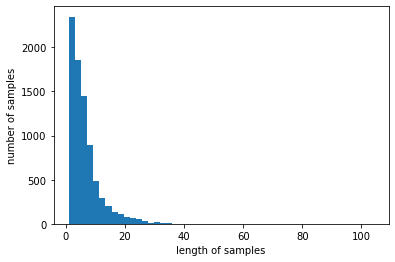

In [173]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [174]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
max_len = 20 #조정
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 96.7974180734856


In [175]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen = max_len)


In [176]:
word_index=list(tokenizer.word_index.keys())
c=pd.DataFrame({'title':[]})
a=''
b=''
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        if X_train[i][j]!=0:
            a=word_index[X_train[i][j]-1]
            b=b+' '+a
    c.loc[i]=b
    b=''

In [178]:
c.to_csv("2021-08-01 00_00_00.csv")